#  Libraray

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.compat.v1.enable_eager_execution()

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load Data

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')

X = train_data.drop(columns = ['id','target'], axis = 1)

binary_obj_columns = ['Gender', 'Customer Type', 'Type of Travel']
numerical_columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']
multical_obj_columns = list(set(X.columns) - set(binary_obj_columns) - set(numerical_columns))

print(f'Number of Binary Features : {len(binary_obj_columns)}')
print(f'Number of Numerical Features : {len(numerical_columns)}')
print(f'Number of Categorical Features : {len(multical_obj_columns)}')

Number of Binary Features : 3
Number of Numerical Features : 4
Number of Categorical Features : 15


# Preprocess

In [3]:
X_train_num = pd.DataFrame()
X_test_num = pd.DataFrame()

X_train_group = pd.DataFrame()
X_test_group = pd.DataFrame()

## Binary -> Label Encoding

In [4]:
X_train_num = pd.DataFrame()
X_test_num = pd.DataFrame()

for col in binary_obj_columns : 
    map_dict = {key : num for num,key in enumerate(train_data[col].unique())}
    X_train_num[col] = train_data[col].map(map_dict)
    X_test_num[col] = test_data[col].map(map_dict)

## Numerical -> Grouping

In [5]:
for col in numerical_columns :     
    X_train_num[col] = train_data[col]
    X_test_num[col] = test_data[col]
    
    data = train_data[col]
    _, bins = pd.qcut(data, 4, retbins=True, labels=False, duplicates='drop')
    X_train_group[col+'_group'] = train_data[col].apply(lambda x : sum([x >= a for a in bins]))
    X_test_group[col+'_group'] = test_data[col].apply(lambda x : sum([x >= a for a in bins]))

## Categorical -> Label Encoding

In [6]:
for col in multical_obj_columns : 
    map_dict = {key : num for num, key in enumerate(sorted(train_data[col].unique()))}
    X_train_group[col] = train_data[col].map(map_dict)
    X_test_group[col] = test_data[col].map(map_dict)

# Set Data

In [7]:
X_train_cat_inputs = [X_train_group.iloc[:,i].values for i in range(X_train_group.shape[1])]
X_test_cat_inputs = [X_train_group.iloc[:,i].values for i in range(X_test_group.shape[1])]

In [8]:
dim_infos = [[x, x//2] for x in X_train_group.nunique()]

In [9]:
X_train_num_inputs = X_train_num.values
X_test_num_inputs = X_test_num.values

# Modeling

In [10]:
class FC_Block(tf.keras.layers.Layer) : 
    def __init__(self, units = 32) : 
        super(FC_Block, self).__init__()
        self.units = units
        self.linear = tf.keras.layers.Dense(units, kernel_initializer = 'he_normal')
        self.batch = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, inputs) : 
        x = self.linear(inputs)
        x = self.batch(x, training = True) 
        x = self.relu(x)
        x = self.dropout(x)

        return x

In [11]:
class EMB_Model(tf.keras.Model) : 
    def __init__(self, dim_infos) : 
        super(EMB_Model, self).__init__()
        self.embedding_layers = [layers.Embedding(inp_dim+1, out_dim) for inp_dim, out_dim in dim_infos]
        self.flatten = layers.Flatten()
        self.cont_norm = layers.BatchNormalization()        
        self.FFC = tf.keras.Sequential([FC_Block(32), FC_Block(8), layers.Dense(1)])
        
    def call(self, inputs) : 
        x_cat, x_num = inputs[0], inputs[1]
        x_cats = []
        for i, x in enumerate(x_cat) : 
            x=  self.embedding_layers[i](x)
            x= self.flatten(x)
            x_cats.append(x)
        
        x_num = self.cont_norm(x_num)
        x = tf.concat(x_cats+[x_num], axis = 1)
        
        x = self.FFC(x)
        return tf.nn.sigmoid(x)
    

# Training

### Get Dataloader

In [12]:
from sklearn.model_selection import train_test_split
data_range = range(3000)
y = train_data['target'].values
random_state = 0


def return_dataset(rs, y ) : 
    train_idx, valid_idx = train_test_split(data_range, shuffle = True, stratify = y, test_size = .4, random_state = rs)

    X_tr_cat_inputs = [x[train_idx] for x in X_train_cat_inputs]
    X_val_cat_inputs = [x[valid_idx] for x in X_train_cat_inputs]

    X_tr_num_inputs = X_train_num_inputs[train_idx]
    X_val_num_inputs = X_train_num_inputs[valid_idx]

    X_train_inputs = [X_tr_cat_inputs, X_tr_num_inputs]
    X_valid_inputs = [X_val_cat_inputs, X_val_num_inputs]
    
    train_inputs = (X_train_inputs, y[train_idx])
    valid_inputs = (X_valid_inputs, y[valid_idx])
    
    return train_inputs, valid_inputs


### Get Callback Modules

In [13]:
def return_callbacks(save_path, patience) : 
    early = tf.keras.callbacks.EarlyStopping('val_loss', patience = patience, mode = 'min')
    mckt = tf.keras.callbacks.ModelCheckpoint(save_path, monitor = 'val_loss', save_weights_only=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = patience // 2, min_lr = 1e-5)

    return [early, mckt, reduce_lr]

### Draw Training Progress

In [14]:
def draw_history(history, need_acc = False) : 
    import matplotlib
    import matplotlib.pyplot as plt
    fig, loss_ax = plt.subplots()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    if need_acc : 
        acc_ax = loss_ax.twinx()
        acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
        acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
        acc_ax.set_ylabel('accuracy')
        acc_ax.legend(loc='upper left')

    plt.show()

### Training

In [15]:
def return_prediction(rs) : 
    batch_size = 1024
    model = EMB_Model(dim_infos)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer, loss_fn, metrics = ['accuracy'])

    model_path = 'EMBNN.h5'
    callbacks = return_callbacks(model_path,10)
    
    train_inputs, valid_inputs = return_dataset(rs, y)

    history = model.fit(train_inputs[0], train_inputs[1],
                         validation_data = valid_inputs,
                         epochs=100,
                        batch_size = batch_size,
                         callbacks = callbacks,
                       verbose = 0)
    model.load_weights(model_path)
    draw_history(history, True)

    pred = model([[X_test_group.iloc[:,i].values for i in range(X_test_group.shape[1])], X_test_num.values])
    pred = pred.numpy().flatten()

    return pred

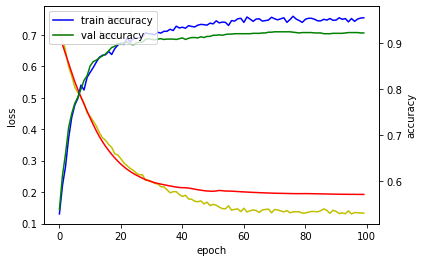

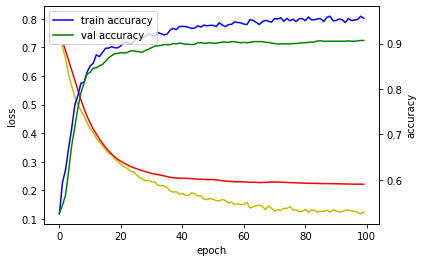

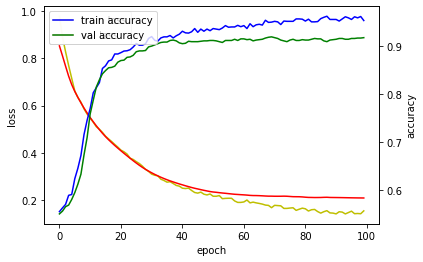

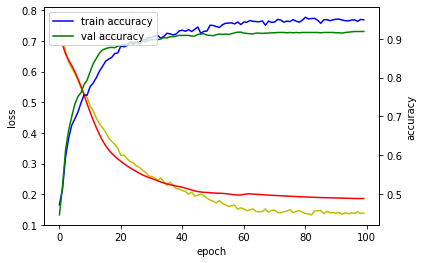

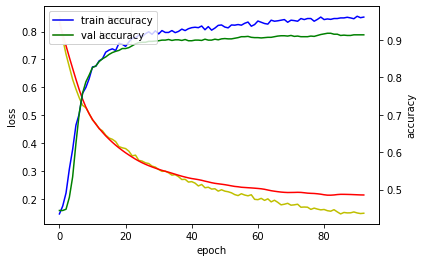

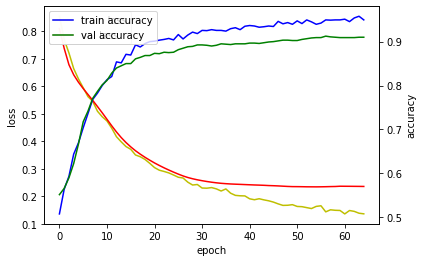

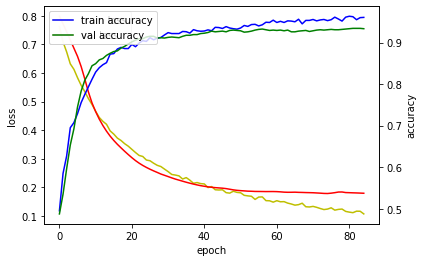

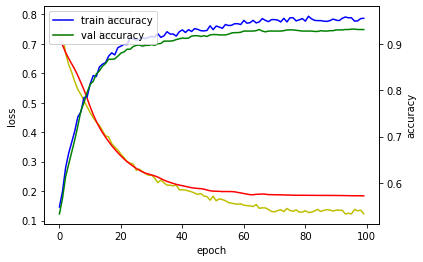

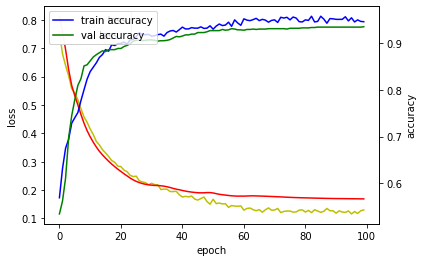

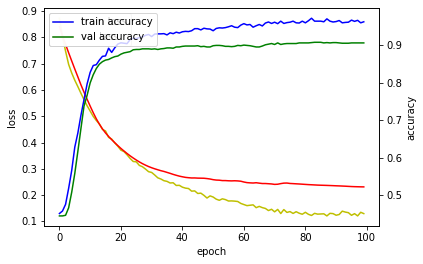

In [16]:
preds = []

for i in range(10) : 
    rs = np.random.randint(1,2**12)
    pred = return_prediction(rs)
    preds.append(pred)

In [17]:
pred = np.mean(preds, axis = 0).round().astype(int)
sample['target'] = pred
sample.to_csv('./Jay Hong EMBEDNN TENSORFLOW.csv', index=False)